In [1]:
import numpy as np
import torch
import torch.nn as nn

import matplotlib.pyplot as plt

In [2]:
# # https://github.com/HazyResearch/hippo-code/blob/master/model/hippo.py

# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# import numpy as np
# import matplotlib.pyplot as plt
# from scipy import signal
# from scipy import linalg as la
# from scipy import special as ss

# def transition(measure, N, **measure_args):
#     if measure == 'legs':
#         q = np.arange(N, dtype=np.float64)
#         col, row = np.meshgrid(q, q)
#         r = 2 * q + 1
#         M = -(np.where(row >= col, r, 0) - np.diag(q))  # 這裡有負號,  paper 有些地方沒寫就是因為放進 A 裡面了
#         T = np.sqrt(np.diag(2 * q + 1))  # D of formula 30 in paper
#         # return M, T
#         A = T @ M @ np.linalg.inv(T)
#         B = np.diag(T)[:, None]

#     return A, B

# def variable_unroll_matrix_sequential(A, u, s=None, variable=True):
#     if s is None:
#         s = torch.zeros_like(u[0])

#     if not variable:
#         A = A.expand((u.shape[0],) + A.shape)
#     # has_batch = len(u.shape) >= len(A.shape)

#     # op = lambda x, y: batch_mult(x.unsqueeze(0), y.unsqueeze(0), has_batch)[0]
#     op = lambda x, y: batch_mult(x.unsqueeze(0), y.unsqueeze(0))[0]

#     return variable_unroll_general_sequential(A, u, s, op, variable=True)

# def variable_unroll_general_sequential(A, u, s, op, variable=True):
#     """ Unroll with variable (in time/length) transitions A with general associative operation

#     A : ([L], ..., N, N) dimension L should exist iff variable is True
#     u : (L, [B], ..., N) updates
#     s : ([B], ..., N) start state
#     output : x (..., N)
#     x[i, ...] = A[i]..A[0] s + A[i..1] u[0] + ... + A[i] u[i-1] + u[i]
#     """

#     if not variable:
#         A = A.expand((u.shape[0],) + A.shape)

#     outputs = []
#     for (A_, u_) in zip(torch.unbind(A, dim=0), torch.unbind(u, dim=0)):
#         s = op(A_, s)
#         s = s + u_
#         outputs.append(s)

#     output = torch.stack(outputs, dim=0)
#     return output

# def batch_mult(A, u, has_batch=None):
#     """ Matrix mult A @ u with special case to save memory if u has additional batch dim

#     The batch dimension is assumed to be the second dimension
#     A : (L, ..., N, N)
#     u : (L, [B], ..., N)
#     has_batch: True, False, or None. If None, determined automatically

#     Output:
#     x : (L, [B], ..., N)
#       A @ u broadcasted appropriately
#     """

#     if has_batch is None:
#         has_batch = len(u.shape) >= len(A.shape)

#     if has_batch:
#         u = u.permute([0] + list(range(2, len(u.shape))) + [1])
#     else:
#         u = u.unsqueeze(-1)
#     v = (A @ u)
#     if has_batch:
#         v = v.permute([0] + [len(u.shape)-1] + list(range(1, len(u.shape)-1)))
#     else:
#         v = v[..., 0]
#     return v

# class HiPPO_LegS(nn.Module):
#     """ Vanilla HiPPO-LegS model (scale invariant instead of time invariant) """
#     def __init__(self, N, max_length=1024, measure='legs', discretization='bilinear'):
#         """
#         max_length: maximum sequence length
#         """
#         super().__init__()
#         self.N = N
#         A, B = transition(measure, N)
#         B = B.squeeze(-1)
#         A_stacked = np.empty((max_length, N, N), dtype=A.dtype)
#         B_stacked = np.empty((max_length, N), dtype=B.dtype)
#         for t in range(1, max_length + 1):
#             At = A / t
#             Bt = B / t
#             if discretization == 'forward':
#                 A_stacked[t - 1] = np.eye(N) + At
#                 B_stacked[t - 1] = Bt
#             elif discretization == 'backward':
#                 A_stacked[t - 1] = la.solve_triangular(np.eye(N) - At, np.eye(N), lower=True)
#                 B_stacked[t - 1] = la.solve_triangular(np.eye(N) - At, Bt, lower=True)
#             elif discretization == 'bilinear':
#                 A_stacked[t - 1] = la.solve_triangular(np.eye(N) - At / 2, np.eye(N) + At / 2, lower=True)
#                 B_stacked[t - 1] = la.solve_triangular(np.eye(N) - At / 2, Bt, lower=True)
#             else: # ZOH
#                 A_stacked[t - 1] = la.expm(A * (math.log(t + 1) - math.log(t)))
#                 B_stacked[t - 1] = la.solve_triangular(A, A_stacked[t - 1] @ B - B, lower=True)
#         self.A_stacked = torch.Tensor(A_stacked) # (max_length, N, N)
#         self.B_stacked = torch.Tensor(B_stacked) # (max_length, N)
#         # print("B_stacked shape", B_stacked.shape)

#         vals = np.linspace(0.0, 1.0, max_length)
#         self.eval_matrix = torch.Tensor((B[:, None] * ss.eval_legendre(np.arange(N)[:, None], 2 * vals - 1)).T)

#     def forward(self, inputs, fast=False):
#         """
#         inputs : (length, ...)
#         output : (length, ..., N) where N is the order of the HiPPO projection
#         """

#         L = inputs.shape[0]

#         inputs = inputs.unsqueeze(-1)
#         u = torch.transpose(inputs, 0, -2)
#         u = u * self.B_stacked[:L]
#         u = torch.transpose(u, 0, -2) # (length, ..., N)

#         if fast:
#             result = variable_unroll_matrix(self.A_stacked[:L], u)
#         else:
#             result = variable_unroll_matrix_sequential(self.A_stacked[:L], u)
#         return result

#     def reconstruct(self, c):
#         a = self.eval_matrix @ c.unsqueeze(-1)
#         return a.squeeze(-1)

In [3]:
from scipy import special as ss

# def my_transition(c_dim, **measure_args):
#   q = torch.arange(0, c_dim, dtype=torch.float64)
#   B = torch.pow(2*q+1, .5)[:, None]  # D of formula 30 in paper
#   A = (B * B.T).tril().fill_diagonal_(0) + (torch.diag(q+1) )
#   return -A, B

class Hippo(nn.Module):
  def __init__(self, dim, c_dim=4):
    super().__init__()
    self.dim = dim
    self.c_dim = c_dim

    q = torch.arange(0, c_dim, dtype=torch.float)
    B = torch.pow(2*q+1, .5) # D of formula 30 in paper
    A = (B * B[:, None]).tril().fill_diagonal_(0) + (torch.diag(q+1) )
    
    self.AT = nn.Parameter(A.T, requires_grad=False) # transpose of a lower triangular matrix
    self.B = nn.Parameter(B, requires_grad=False)
    self.Lf = nn.Linear(self.dim, 1)

  def forward(self, c, h, t):
    # f = self.Lf(h)
    f = h
    return c @ (torch.eye(self.c_dim) - self.AT/t) + (f * self.B)/t
  
  def reconstruct(self, c, density=50):
    """
    x: shape [n, 1]
    """
    vals = np.linspace(0.0, 1.0, density)
    eval_matrix = self.B[:, None] * ss.eval_legendre(np.arange(self.c_dim)[:, None], 2*vals-1).astype(np.float32)
    # print(eval_matrix)
    return c @ eval_matrix
    # return torch.einsum('nd,d', unscaled_legendre, (legendre_scale*normalizing_scale)[:self.c_dim+1])

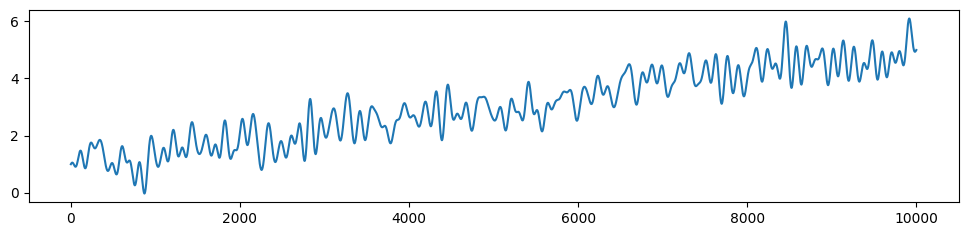

In [4]:
T = 10000
dt = 1e-2
nbatches = 10

import torch.utils.data as data
import nengo
class FunctionApprox(data.TensorDataset):

    def __init__(self, length, dt, nbatches, freq=10.0, seed=0):
        rng = np.random.RandomState(seed=seed)
        process = nengo.processes.WhiteSignal(length * dt, high=freq, y0=0)
        X = np.empty((nbatches, length, 1))
        for i in range(nbatches):
            X[i, :] = process.run_steps(length, dt=dt, rng=rng)
            # X[i, :] /= np.max(np.abs(X[i, :]))
        X = torch.Tensor(X)
        super().__init__(X, X)

test = FunctionApprox(T, dt, nbatches, freq=1.0, seed=1)
test_loader = torch.utils.data.DataLoader(test, batch_size=1, shuffle=False)
it = iter(test_loader)
f, _ = next(it)
f, _ = next(it)
f = f.squeeze(0).squeeze(-1)
f += np.linspace(1, 5, 10000)
plt.figure(figsize=[12,2.5])
plt.plot(range(f.shape[0]), f)

In [5]:
c_dim = 32

In [6]:
hippo = Hippo(1, c_dim)

cs = []
c = torch.zeros([1, c_dim], dtype=torch.float)
for i in range(f.shape[0]):
  c = hippo(c, f[i], i+1)
  cs.append(c)
cs = torch.stack(cs, dim=1)[0]

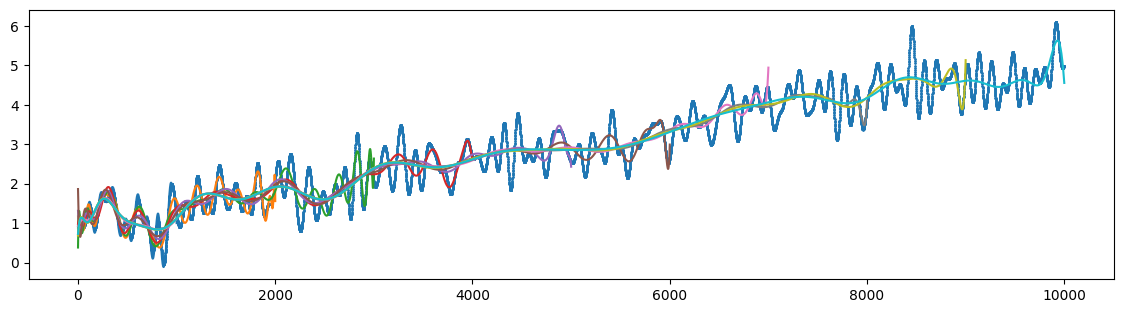

In [7]:
plt.figure(figsize=[14,3.5])
plt.scatter(range(len(f)), f, s=1)

printing_interval = 1000
# initial_l = 100
# plt.plot(np.linspace(1, initial_l, 10000), recons[initial_l])
for l in range(printing_interval, cs.shape[0], printing_interval):
  recons = hippo.reconstruct(cs[l], density=l)
  
  plt.plot(np.linspace(1, l+1, l), recons)

recons = hippo.reconstruct(cs[-1], density=10000)
plt.plot(np.linspace(1, 10000+1, 10000), recons)

In [8]:
# legs = HiPPO_LegS(c_dim, T, discretization='forward')
# f_legs = legs(f)
# print(f_legs[0])
# recons = legs.reconstruct(f_legs)
# print(F.mse_loss(f, recons[-1]))


# plt.figure(figsize=[14,3.5])
# plt.scatter(range(f.shape[0]), f, s=1, marker='.')

# printing_interval = 1000
# initial_l = 100
# plt.plot(np.linspace(1, initial_l, 10000), recons[initial_l])
# for l in range(printing_interval, recons.shape[0], printing_interval):
#   plt.plot(np.linspace(1, l+1, 10000), recons[l])
# plt.plot(np.linspace(1, 10000+1, 10000), recons[-1])